In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [95]:
from pathlib import Path
import xarray as xa
import numpy as np
import math as m
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

#issues with numpy deprecation in pytorch_env
from coralshift.processing import data

## Load in data

In [213]:
# load in xa_array
array_path = Path("/Volumes/MRes Drive/global_ocean_reanalysis/monthly_means/baseline_area/coral_climate_1_12.nc")
xa_coral_climate_1_12 = xa.open_dataset(array_path)
xa_coral_climate_1_12

<xarray.Dataset>
Dimensions:                  (latitude: 187, longitude: 137, time: 336)
Coordinates:
  * latitude                 (latitude) float64 -8.755 -8.838 ... -24.17 -24.25
  * longitude                (longitude) float64 141.4 141.5 ... 152.7 152.7
    depth                    float32 ...
  * time                     (time) datetime64[ns] 1993-01-16T12:00:00 ... 20...
Data variables: (12/13)
    spatial_ref              (latitude, longitude, time) int64 ...
    coral_algae_1-12_degree  (latitude, longitude, time) float64 ...
    mlotst                   (latitude, longitude, time) float32 ...
    siconc                   (latitude, longitude, time) float32 ...
    thetao                   (latitude, longitude, time) float32 ...
    usi                      (latitude, longitude, time) float32 ...
    ...                       ...
    bottomT                  (latitude, longitude, time) float32 ...
    vsi                      (latitude, longitude, time) float32 ...
    vo                       (latitude, longitude, time) float32 ...
    uo                       (latitude, longitude, time) float32 ...
    so                       (latitude, longitude, time) float32 ...
    zos                      (latitude, longitude, time) float32 ...

In [214]:
# return only parameter values (exclude target and spatial reference)
parameter_names = list(set(list(xa_coral_climate_1_12.data_vars))-set(['spatial_ref', 'coral_algae_1-12_degree']))
xa_coral_climate_1_12_features = xa_coral_climate_1_12[parameter_names]

In [215]:
# create 3D array from xarray dataset variables. Shape: (num_samples, num_parameters, sequence_len)
X_with_nans = data.xa_ds_to_3d_numpy(xa_coral_climate_1_12_features)
print(f'X_with_nans shape (num_samples: {X_with_nans.shape[0]}, total num_parameters (includes nans parameters): {X_with_nans.shape[1]}, sequence_len: {X_with_nans.shape[2]})')

for i, param in enumerate(xa_coral_climate_1_12_features.data_vars):
    print(f"{i}: {param}")

100%|██████████| 11/11 [00:00<00:00, 10155.70it/s]


X_with_nans shape (num_samples: 25619, total num_parameters (includes nans parameters): 11, sequence_len: 336)
0: bottomT
1: so
2: usi
3: thetao
4: vsi
5: uo
6: sithick
7: mlotst
8: vo
9: zos
10: siconc


In [216]:
X_with_nans.shape

(25619, 11, 336)

#### Remove observations for which there are nan values

99% sure these are are just gridcells containing land. Would be a good thing to investigate, however.

In [220]:
def reshape_to_1d(array):
    """Reshape a 2D array to a 1D array.

    Parameters:
    -----------
    array : numpy.ndarray
        2D array to be reshaped.

    Returns:
    --------
    numpy.ndarray
        1D array representing the reshaped input array.
    """
    return array.flatten()

    
def map_to_2d(array_1d, shape):
    """Map a 1D array back to the original 2D shape.

    Parameters:
    -----------
    array_1d : numpy.ndarray
        1D array to be mapped.

    shape : tuple
        Shape of the original 2D array.

    Returns:
    --------
    numpy.ndarray
        2D array with values from the 1D array mapped to their correct coordinate points.
    """
    return array_1d.reshape(shape)

In [218]:
X = X_with_nans
# problem, probably with sea ice features

In [219]:
# filter out columns that contain entirely NaN values
col_mask = ~np.all(np.isnan(X), axis=(0,2)) # boolean mask indicating which columns to keep
masked_cols = X[:, col_mask, :] # keep only the columns that don't contain entirely NaN values
print("masked_cols shape:", masked_cols.shape)

masked_cols shape: (25619, 9, 336)


In [221]:
# filter out all rows which contain any NaN values
row_mask = ~np.any(np.isnan(masked_cols), axis=1) # boolean mask indicating which rows to keep
masked_cols_rows = masked_cols[row_mask[:,0], :, :] # keep only the rows that don't contain any NaN values
masked_cols_rows.shape

(14766, 9, 336)

In [223]:
# filter out all depths which contain any NaN values
depth_mask = ~np.any(np.isnan(masked_cols_rows), axis=(0,1)) # boolean mask indicating which depths to keep
X = masked_cols_rows[:, :, depth_mask] # keep only the depths that don't contain any NaN values
X = np.swapaxes(X, 1, 2)
print(f"X shape: {X.shape}")

X shape: (14766, 276, 9)


In [224]:
# create target from coral ground truth. Shape: (num_samples, 1)
# TODO: not sure if this is shuffling the values when reshaping
y_with_nans = np.array(xa_coral_climate_1_12["coral_algae_1-12_degree"].sel(
    time=xa_coral_climate_1_12.time[-1])).reshape(-1, 1)
# remove ys with nan values in other variables
y = y_with_nans[row_mask[:,0]]

print(f"y_with_nans shape: {y_with_nans.shape}")
print(f"y shape: {y.shape}")

y_with_nans shape: (25619, 1)
y shape: (14766, 1)


In [225]:
def filter_out_nans(X_with_nans, y_with_nans):
    # must be in shape (num_samples, num_params, seq_length)

    # filter out columns that contain entirely NaN values
    col_mask = ~np.all(np.isnan(X_with_nans), axis=(0,2)) # boolean mask indicating which columns to keep
    masked_cols = X_with_nans[:, col_mask, :] # keep only the columns that don't contain entirely NaN values

    # filter out all rows which contain any NaN values
    row_mask = ~np.any(np.isnan(masked_cols), axis=1) # boolean mask indicating which rows to keep
    masked_cols_rows = masked_cols[row_mask[:,0], :, :] # keep only the rows that don't contain any NaN values

    # filter out all depths which contain any NaN values
    depth_mask = ~np.any(np.isnan(masked_cols_rows), axis=(0,1)) # boolean mask indicating which depths to keep
    X = masked_cols_rows[:, :, depth_mask] # keep only the depths that don't contain any NaN values
    # swap axes so shape (num_samples, seq_length, num_params)
    X = np.swapaxes(X, 1, 2)

    y = y_with_nans[row_mask[:,0]]

    return X, y

In [227]:
X, y = filter_out_nans(X_with_nans, np.array(xa_coral_climate_1_12["coral_algae_1-12_degree"].isel(time=-1)).reshape(-1, 1))
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (14766, 276, 9)
y shape: (14766, 1)


In [19]:
X.shape

(14766, 276, 9)

## GRU function definitions 

In [308]:
# Define Gated Recurrent Unit model class in TensorFlow
class gru_model(tf.keras.Model):
    # initialise class instance to define layers of the model
    def __init__(self, rnn_units: list[int], num_layers: int):
        """Sets up a GRU model architecture with multiple layers and dense layers for mapping the outputs of the GRU 
        layers to a desired output shape

        Parameters
        ----------
        rnn_units (list[int]): list containing the number of neurons to use in each layer
        num_layers (int): number of layers in GRU model
        """
        super(gru_model, self).__init__()   # initialise GRU model as subclass of tf.keras.Model
        # store values for later use
        self.num_layers = num_layers    # number of layers in GRU model
        self.rnn_units = rnn_units
        # define model layers: creating new `tf.keras.layers.GRU` layer for each iteration
        self.grus = [tf.keras.layers.GRU(rnn_units[i],  # number (integer) of rnn units/neurons to use in each model layer
                                   return_sequences=True,   # return full sequence of outputs for each timestep
                                   return_state=True) for i in range(num_layers)] # return last hidden state of RNN at end of sequence
        
        # dense layers are linear mappings of RNN layer outputs to desired output shape
        self.w1 = tf.keras.layers.Dense(10) # 10 units
        self.w2 = tf.keras.layers.Dense(1)  # 1 unit (dimension 1 required before final sigmoid function)


    def call(self, inputs: np.ndarray, training: bool=False):
        """Processes an input sequence of data through several layers of GRU cells, followed by a couple of
        fully-connected dense layers, and outputs the probability of an event happening.
        
        Parameters
        ----------
        inputs (np.ndarray): input tensor of shape (batch_size, seq_length, features)
            batch_size - defines the size of the sample drawn from datapoints
            seq_length - number of timesteps in sequence
            features - number of features associated with each datapoint
        training (bool, defaults to False): True if model is in training, False if in inference mode

        Returns
        -------
        target: probability of an event occuring, with shape (batch_size, 1)
        """
        # input shape: (batch_size, seq_length, features)
       
        assert self.num_layers == len(self.rnn_units)

        # check that input tensor has correct shape
        if (len(inputs.shape) != 3):
            print(f"Incorrect shape of input tensor. Expected 3D array. Recieved {len(inputs.shape)}D array.")

        # print('input dim ({}, {}, {})'.format(inputs.shape[0], inputs.shape[1], inputs.shape[2]))
        whole_seq = inputs

        # iteratively passes input tensor to GRU layers, overwritting preceding sequence 'whole_seq'
        for layer_num in range(self.num_layers):
            whole_seq, final_s = self.grus[layer_num](whole_seq, training=training)

        # adding extra layers
        target = self.w1(final_s)   # final hidden state of last layer used as input to fully connected dense layers...
        target = tf.nn.relu(target) # via ReLU activation function
        target = self.w2(target)    # final hidden layer must have dimension 1 
        
        # obtain a probability value between 0 and 1
        target = tf.nn.sigmoid(target)
        
        return target

    
def negative_log_likelihood(y: np.ndarray, y_pred: np.ndarray) -> float:
    """Compute binary cross-entropy loss between ground-truth binary labels and predicted probabilities.
    N.B. Binary cross-entropy loss defined as the negative log likelihood of the binary labels given the predicted
    probabilities
    
    Parameters
    ----------
    y (np.ndarray): true binary labels, where 0 represents the negative class
    y_pred (np.ndarray): predicted labels (as probability value between 0 and 1)

    Returns
    -------
    float: negative log likelihood loss computed using binary cross-entropy loss between 'y' and 'y_pred'
    """
    bce = tf.keras.losses.BinaryCrossentropy()    
    return bce(y, y_pred)


def build_graph():
    
    # compile function as graph using tf's autograph feature: leads to faster execution times, at expense of limitations
    # to Python objects/certain control flow structures (somewhat relaxed by experimental_relax_shapes)
    @tf.function(experimental_relax_shapes=True)
    def train_step(gru: tf.keras.Model, optimizer: tf.keras.optimizers.Optimizer, X: np.ndarray, y: np.ndarray, 
        training: bool=True, batch_size: int=None) -> tuple[np.ndarray, float]:
        """Train model using input `X` and target data `y` by computing gradients of the loss (via 
        negative_log_likelihood)
        
        Parameters
        ----------
        y (np.ndarray): true binary labels, where 0 represents the negative class
        y_pred (np.ndarray): predicted labels (as probability value between 0 and 1)

        Returns
        -------
        float: negative log likelihood loss computed using binary cross-entropy loss between 'y' and 'y_pred'
        """
        if training:
            num_samples = X.shape[0]
            num_batches = num_samples // batch_size

            total_loss = 0.0
            for batch in tqdm(range(num_batches), desc="batches", position=1, leave=False):
                start_idx = batch * batch_size
                end_idx = (batch + 1) * batch_size

                X_batch = X[start_idx:end_idx]
                y_batch = y[start_idx:end_idx]

                with tf.GradientTape(persistent=True) as tape:
                    y_pred = gru(X, training) 
                    xent = negative_log_likelihood(y, y_pred)
                
                gradients = tape.gradient(xent, gru.trainable_variables)
                optimizer.apply_gradients(zip(gradients, gru.trainable_variables))

                total_loss += xent

            # TODO: return iterative loss
            average_loss = total_loss / num_batches
            # return predicted output values and total loss value
            return y_pred, xent

    # set default float type
    tf.keras.backend.set_floatx('float32')
    return train_step

In [ ]:
# TODO: optionally replace batching with spatial batching

### Test GRU functions

In [232]:
# initialise GRU model with 500 hidden layers, one GRU unit per layer 
g_model = gru_model([500], 1) # N.B. [x] is number of hidden layers in GRU network

In [301]:
g_model(X[:32])

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[0.7879325 ],
       [0.78600794],
       [0.78608435],
       [0.7845568 ],
       [0.7832787 ],
       [0.7820495 ],
       [0.78224695],
       [0.780965  ],
       [0.7786794 ],
       [0.7734331 ],
       [0.7680314 ],
       [0.765528  ],
       [0.76523924],
       [0.7651379 ],
       [0.7669401 ],
       [0.76876265],
       [0.76992863],
       [0.7699409 ],
       [0.7696086 ],
       [0.7691227 ],
       [0.76914644],
       [0.7686389 ],
       [0.76649433],
       [0.7625074 ],
       [0.75879955],
       [0.7580424 ],
       [0.757753  ],
       [0.75560147],
       [0.75379467],
       [0.75092214],
       [0.74899673],
       [0.7443951 ]], dtype=float32)>

In [93]:
# # Create latitude, longitude, and time coordinates
# latitude = np.linspace(0, 30, 15)
# longitude = np.linspace(0, 10, 10)
# time = pd.date_range(start='1/1/2018', end='1/08/2018')

# # Create target array
# target = np.zeros((len(latitude), len(longitude), len(time)))
# target[:len(latitude) // 3, :, :] = 1

# # Create variables var1, var2, var3
# var1 = np.where(target == 1, 100, 10)
# var2 = np.where(target == 1, 100, 10)
# var3 = np.where(target == 1, 100, 10)

# # Create xarray dataset
# dataset = xa.Dataset(
#     {
#         'var1': (['latitude', 'longitude', 'time'], var1),
#         'var2': (['latitude', 'longitude', 'time'], var2),
#         'var3': (['latitude', 'longitude', 'time'], var3),
#         'target': (['latitude', 'longitude', 'time'], target),
#     },
#     coords={
#         'latitude': latitude,
#         'longitude': longitude,
#         'time': time,
#     },
# )
# dataset

<xarray.Dataset>
Dimensions:    (latitude: 15, longitude: 10, time: 8)
Coordinates:
  * latitude   (latitude) float64 0.0 2.143 4.286 6.429 ... 25.71 27.86 30.0
  * longitude  (longitude) float64 0.0 1.111 2.222 3.333 ... 7.778 8.889 10.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-01-08
Data variables:
    var1       (latitude, longitude, time) int64 100 100 100 100 ... 10 10 10 10
    var2       (latitude, longitude, time) int64 100 100 100 100 ... 10 10 10 10
    var3       (latitude, longitude, time) int64 100 100 100 100 ... 10 10 10 10
    target     (latitude, longitude, time) float64 1.0 1.0 1.0 ... 0.0 0.0 0.0

In [161]:
# made unnecssary due to isel indexing
# def pixels_to_coord_diff(xa_ds: xa.Dataset | xa.DataArray, window_dim: int, coord: str) -> list[float, float]:
#     return float(window_dim * np.diff(data.min_max_of_coords(xa_ds, coord)) / len(list(xa_coral_climate_1_12[coord])))

In [246]:
def sample_spatial_batch(xa_ds: xa.Dataset, lat_lon_starts: tuple=(0,0), window_dims: tuple[int,int] = (6,6), 
    coord_range: tuple[float]=None, variables: list[str] = None) -> np.ndarray:
    """Sample a spatial batch from an xarray Dataset.

    Parameters
    ----------
        xa_ds (xa.Dataset): The input xarray Dataset.
        lat_lon_starts (tuple): Tuple specifying the starting latitude and longitude indices of the batch.
        window_dims (tuple[int, int]): Tuple specifying the dimensions (number of cells) of the spatial window.
        coord_range (tuple[float]): Tuple specifying the latitude and longitude range (in degrees) of the spatial 
            window. If provided, it overrides the window_dims parameter.
        variables (list[str]): List of variable names to include in the spatial batch. If None, includes all variables.

    Returns
    -------
        np.ndarray: The sampled spatial batch as a NumPy array.

    Notes
    -----
        - The function selects a subset of the input dataset based on the provided latitude, longitude indices, and window dimensions.
        - If a coord_range is provided, it is used to compute the latitude and longitude indices of the spatial window.
        - The function returns the selected subset as a NumPy array.

    Example
    -------
        # Sample a spatial batch from an xarray Dataset
        dataset = ...
        lat_lon_starts = (2, 3)
        window_dims = (6, 6)
        coord_range = (2.5, 3.5)
        variables = ['var1', 'var2', 'var3']
        spatial_batch = sample_spatial_batch(dataset, lat_lon_starts, window_dims, coord_range, variables)
    """
    # N.B. have to be careful when providing coordinate ranges for areas with negative coords. TODO: make universal
    lat_start, lon_start = lat_lon_starts[0], lat_lon_starts[1]
    if not coord_range:
        subset = xa_ds.isel({"latitude": slice(lat_start,window_dims[0]), 
                            "longitude": slice(lon_start,window_dims[1])})
    else:
        lat_cells, lon_cells = coord_range[0], coord_range[1]
        subset = xa_ds.sel({"latitude": slice(lat_start,lat_start+lat_cells), 
                            "longitude": slice(lon_start,lon_start+lon_cells)})

    lat_slice = subset["latitude"].values
    lon_slice = subset["longitude"].values
    time_slice = subset["time"].values

    return subset, {"latitude": lat_slice, "longitude": lon_slice, "time": time_slice}


In [237]:
slice(2,5)

slice(2, 5, None)

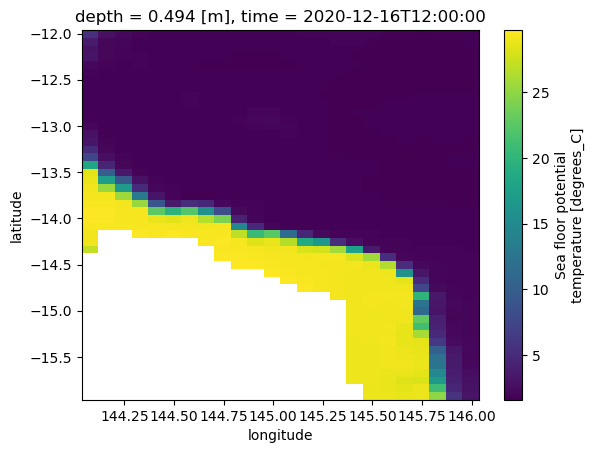

In [208]:
subsample["bottomT"].isel(time=-1).plot()

In [244]:
sample_spatial_batch(xa_coral_climate_1_12,lat_lon_starts=(-16,144), coord_range=(-4,2))["coral_algae_1-12_degree"]

TypeError: tuple indices must be integers or slices, not str

In [247]:
xa_coral_climate_1_12_working = xa_coral_climate_1_12

In [259]:
# [lat_lon_vals_dict.items() for key in ["latitude", "longitude"]]
{key: lat_lon_vals_dict[key] for key in ["latitude", "longitude"]}

{'latitude': array([-12.0048011 , -12.08813443, -12.17146776, -12.2548011 ,
        -12.33813443, -12.42146776, -12.5048011 , -12.58813443,
        -12.67146776, -12.7548011 , -12.83813443, -12.92146776,
        -13.0048011 , -13.08813443, -13.17146776, -13.2548011 ,
        -13.33813443, -13.42146776, -13.5048011 , -13.58813443,
        -13.67146776, -13.7548011 , -13.83813443, -13.92146776,
        -14.0048011 , -14.08813443, -14.17146776, -14.2548011 ,
        -14.33813443, -14.42146776, -14.5048011 , -14.58813443,
        -14.67146776, -14.7548011 , -14.83813443, -14.92146776,
        -15.0048011 , -15.08813443, -15.17146776, -15.2548011 ,
        -15.33813443, -15.42146776, -15.5048011 , -15.58813443,
        -15.67146776, -15.7548011 , -15.83813443, -15.92146776]),
 'longitude': array([144.07761715, 144.16095048, 144.24428381, 144.32761715,
        144.41095048, 144.49428381, 144.57761715, 144.66095048,
        144.74428381, 144.82761715, 144.91095048, 144.99428381,
        145.0

In [264]:
sub_y_nans.shape

(1152, 1)

In [297]:
(list(subsample.data_vars))

['bottomT',
 'so',
 'usi',
 'thetao',
 'vsi',
 'uo',
 'sithick',
 'mlotst',
 'vo',
 'zos',
 'siconc']

In [311]:
# sub_X = np.moveaxis(np.array(test_array), 2, 1)
sub_X.shape

(1152, 336, 11)

In [314]:
col_mask = ~np.all(np.isnan(test_array), axis=(0,2))
sub_X = test_array[:, col_mask, :]

In [315]:
sub_X.shape

(1152, 9, 336)

In [316]:
# sample subset
subsample, lat_lon_vals_dict = sample_spatial_batch(xa_coral_climate_1_12_features,lat_lon_starts=(-12,144), coord_range=(-4,2))
# convert to ndarray
test_array = data.xa_ds_to_3d_numpy(subsample)
subsample_all, _ = sample_spatial_batch(xa_coral_climate_1_12,lat_lon_starts=(-16,144), coord_range=(-4,2))
sub_y_nans = (np.array(subsample_all["coral_algae_1-12_degree"].isel(time=-1))).reshape(-1, 1)
# remove nans
#sub_X, sub_y = filter_out_nans(test_array, sub_y_nans)
# testing, so replace nans with -1
# filter out columns that contain entirely NaN values
col_mask = ~np.all(np.isnan(test_array), axis=(0,2)) # boolean mask indicating which columns to keep
sub_X = test_array[:, col_mask, :] # keep only the columns that don't contain entirely NaN values

sub_X = np.moveaxis(np.array(sub_X), 2, 1)
sub_y = sub_y_nans
sub_X[np.isnan(sub_X)] = -10000
sub_y[np.isnan(sub_y)] = -10000

### train/predict
# if training:
    # assign epoch output to dataset
# if testing:
predicted = g_model(sub_X, training=False)
    # assign output predictions to dataset


100%|██████████| 11/11 [00:00<00:00, 15358.64it/s]


In [320]:
original_shape[:2]

(48, 24)

In [321]:

# reshape to original dimensions
original_shape = [subsample.dims[d] for d in ['latitude', 'longitude', 'time']]
original_shape += [len(list(subsample.data_vars))]
original_shape = tuple(original_shape)

output = predicted.numpy().reshape(original_shape[:2])

# Create a new variable in the dataset using the output subset
xa_coral_climate_1_12_working['output'] = xa.DataArray(output, dims=['latitude', 'longitude'], coords={key: lat_lon_vals_dict[key] for key in ["latitude", "longitude"]})

lat_start, lat_end = lat_lon_vals["latitude"].min(), lat_lon_vals["latitude"].max()
lon_start, lon_end = lat_lon_vals["longitude"].min(), lat_lon_vals["longitude"].max()

# Set values outside the subset range to NaN
xa_coral_climate_1_12_working['output'] = xa_coral_climate_1_12_working['output'].where((xa_coral_climate_1_12_working['output'].latitude >= lat_start) & (xa_coral_climate_1_12_working['output'].latitude <= lat_end) &
                                      (xa_coral_climate_1_12_working['output'].longitude >= lon_start) & (xa_coral_climate_1_12_working['output'].longitude <= lon_end), np.nan)


                                      


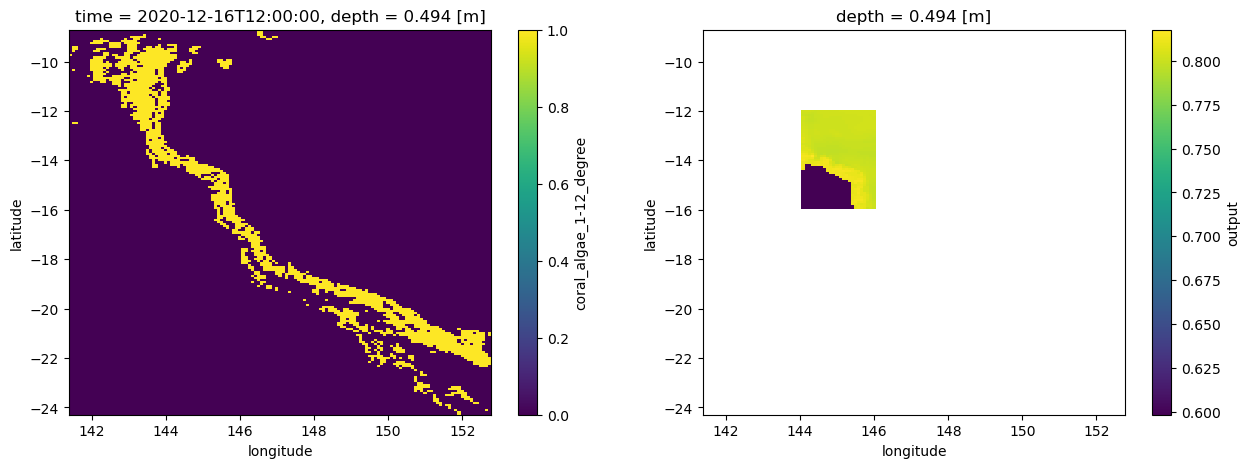

In [330]:
# visualise result
fig, ax = plt.subplots(1,2, figsize=[15,5])

xa_coral_climate_1_12_working["coral_algae_1-12_degree"].isel(time=-1).plot(ax=ax[0])
xa_coral_climate_1_12_working["output"].plot(ax=ax[1])

In [ ]:
def subset_to_dataset_var(xa_ds: xa.Dataset | xa.DataArray, subset_vals: np.ndarray, dims: list=['latitude', 'longitude', "time"]):

In [236]:
predicted

<tf.Tensor: shape=(859, 1), dtype=float32, numpy=
array([[0.6075491 ],
       [0.6384492 ],
       [0.6448065 ],
       [0.64654434],
       [0.6526113 ],
       [0.6625537 ],
       [0.6718456 ],
       [0.6738189 ],
       [0.6762037 ],
       [0.67750883],
       [0.67974144],
       [0.67838037],
       [0.6772377 ],
       [0.6754122 ],
       [0.6730943 ],
       [0.6724197 ],
       [0.6726908 ],
       [0.67256516],
       [0.6714608 ],
       [0.67124975],
       [0.66959745],
       [0.6692888 ],
       [0.6689157 ],
       [0.6688298 ],
       [0.62081397],
       [0.6379606 ],
       [0.6379497 ],
       [0.6408477 ],
       [0.65186745],
       [0.66313595],
       [0.67250794],
       [0.67426777],
       [0.6767674 ],
       [0.6770727 ],
       [0.6779047 ],
       [0.6777035 ],
       [0.67552257],
       [0.6736367 ],
       [0.67255753],
       [0.6709388 ],
       [0.67086715],
       [0.670755  ],
       [0.67273647],
       [0.6734034 ],
       [0.6721408 ],
     

In [31]:
test_x_train = np.append(100*np.ones((50,50,5)), 1*np.ones((50,50,5)), 0)
test_y_train = np.append(np.ones(50,), np.zeros(50,))


print("test_x_train:", test_x_train.shape)
# print("x_test:", x_test.shape)
print("test_y_train:", test_y_train.shape)
# print("y_test:", y_test.shape)


test_x_train: (100, 50, 5)
test_y_train: (100,)


In [30]:
array = np.random.normal(size = (32, 20, 1))    # shape: (num_samples, sequence_length, num_features)
y_dud = np.random.choice([0, 1], size = 32)
print("array shape:", array.shape)
print("y_dud shape:", y_dud.shape)

x_train, y_train = X[:500], y[:500].reshape(500,)
# x_test, y_test = X[5000:6000], y[5000:6000].reshape((1000,))

print("x_train:", x_train.shape)
# print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
# print("y_test:", y_test.shape)


array shape: (32, 20, 1)
y_dud shape: (32,)
x_train: (500, 276, 9)
y_train: (500,)


In [38]:
# check that untrained model runs (should output array of non-nan values)
# g_model(x_train)
g_model(test_x_train)

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
       [0.25181633],
     

In [39]:
# initialize optimiser: will need hyperparameter scan for learning rate and others
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
optimizer = tf.keras.optimizers.Adam(3e-4)

In [40]:
with tf.device("/CPU:0"):
    num_epochs = 5
    num_batches = 100
    tr_step = build_graph()
    for epoch in tqdm(range(num_epochs), desc= " epochs", position = 0):
        # y_pred, average_loss = tr_step(g_model, optimizer, x_train, y_train, batch_size=32, training=True)
        y_pred, average_loss = tr_step(g_model, optimizer, test_x_train, test_y_train, batch_size=32, training=True)
        
        
        
        # for batch in range(num_batches):
        #     array, y  = batcher_fun(X, 32, 276 
        #     #training = True)# shapes: (batch_s, seq_l, features), (batch_s, 1)
        #     )
        #     y_pred, xent = tr_step(g_model, optimizer, X[:32], y, training=True)
            
        #  ## validation set 
        #  ## test_set 



 epochs: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


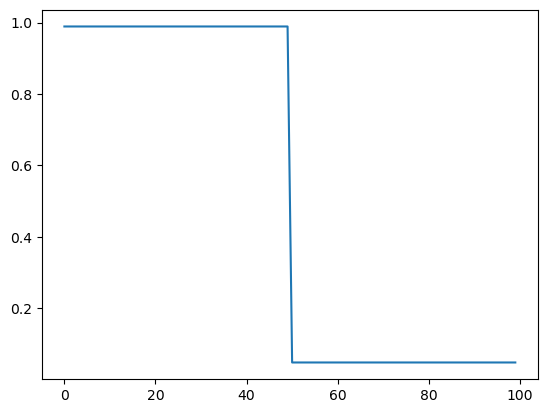

In [45]:
plt.plot(g_model(test_x_train[:],training=False).numpy())

In [48]:
predicted = g_model(X[:5610],training=False)

In [45]:
X.shape

(14766, 276, 9)

In [46]:
xa_coral_climate_1_12["coral_algae_1-12_degree"].isel(time=-1)

<xarray.DataArray 'coral_algae_1-12_degree' (latitude: 187, longitude: 137)>
[25619 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -8.755 -8.838 -8.921 ... -24.09 -24.17 -24.25
  * longitude  (longitude) float64 141.4 141.5 141.6 141.7 ... 152.6 152.7 152.7
    depth      float32 ...
    time       datetime64[ns] 2020-12-16T12:00:00
Attributes:
    grid_mapping:  spatial_ref

In [47]:
30*187

5610

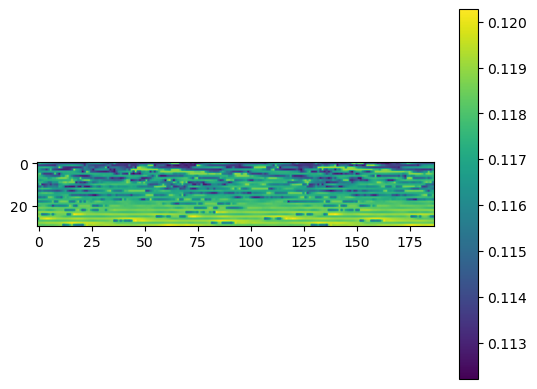

In [50]:
fig, ax = plt.subplots()
out = ax.imshow(predicted.numpy().reshape(30,187))
fig.colorbar(out, ax=ax)

In [ ]:
np.sqrt(500)

In [ ]:
xa_coral_climate_1_12_features

In [ ]:
xa_coral_climate_1_12["coral_algae_1-12_degree"].isel(time=-1)

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[0.48987713],
       [0.48983145],
       [0.4898312 ],
       [0.48977476],
       [0.48978093],
       [0.48963964],
       [0.48977694],
       [0.48981258],
       [0.49084353],
       [0.49521285],
       [0.49789393],
       [0.49701864],
       [0.49619222],
       [0.49632597],
       [0.49642646],
       [0.49654403],
       [0.49661574],
       [0.49668312],
       [0.4969967 ],
       [0.49713624]], dtype=float32)>

In [ ]:
fig, ax = plt.subplots()
out = ax.imshow(y_pred.numpy().reshape(20,25))
fig.colorbar(out, ax=ax)

In [ ]:
sum((y_pred > 0.5).numpy())

In [ ]:
# check log likelihood is computable
negative_log_likelihood(y[:32], g_model(X[:32]))

## Train and test GRU

In [ ]:
# define batcher function (by space and time)

In [ ]:
def batcher_fun(X, y, batch_size, seq_len):
    """
    A function to prepare the data for training the LSTM.
    
    :param data: The input data to the LSTM.
    :param batch_size: The number of samples in each batch.
    :param seq_len: The sequence length of each sample.
    
    :return: A tuple of (batch_x, batch_y), where batch_x is a numpy array of shape (batch_size, seq_len, num_features) 
             and batch_y is a numpy array of shape (batch_size, num_classes).
    """
    num_samples = len(data)
    num_batches = int(num_samples / batch_size)
    num_features = data.shape[1]
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        
        batch_x = np.zeros((batch_size, seq_len, num_features))
        batch_y = np.zeros((batch_size, 1))
        
        for j in range(start_idx, end_idx):
            sample = data[j]
            X = sample[:-1]
            y = y[]
            
            batch_x[j - start_idx] = x.reshape((seq_len, num_features))
            batch_y[j - start_idx, y] = 1
            
        yield batch_x, batch_y


In [ ]:
with tf.device("/CPU:0"):
    num_epochs = 1
    num_batches = 100
    tr_step = build_graph()
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            array, y  = batcher_fun(X, 32, 276 
            #training = True)# shapes: (batch_s, seq_l, features), (batch_s, 1)
            )
            y_pred, xent = tr_step(g_model, optimizer, X[:32], y, training=True)
            
         ## validation set 
         ## test_set 

In [ ]:
y_pred

# Copypasta

[Source](https://github.com/christianversloot/machine-learning-articles/blob/main/build-an-lstm-model-with-tensorflow-and-keras.md)

In [ ]:
X.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam # https://stackoverflow.com/questions/75356826/attributeerror-adam-object-has-no-attribute-get-updates
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model configuration
additional_metrics = ["accuracy"]
# batch_size = 128
batch_size = 32
# embedding_output_dims = 15
# embedding_output_dims = 10
loss_function = BinaryCrossentropy()
# max_sequence_length = 300
max_sequence_length = 276
# num_distinct_words = 5000
# num_distinct_words = 10000
number_of_epochs = 5
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()

In [ ]:
# Load dataset
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)
x_train, y_train = X[:5000], y[:5000].reshape((5000,))
x_test, y_test = X[5000:6000], y[5000:6000].reshape((1000,))

print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

In [ ]:
# Pad all sequences: keras requires sequences of equal lengths. Should be handled in pre-processing, but here for now for security
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

# (number_samples, sequence_length, num_features)
print("padded_inputs:", padded_inputs.shape)
print("padded_inputs_test:", padded_inputs_test.shape)

In [ ]:
padded_inputs = pad_sequences(x_train[:,:,0], maxlen=max_sequence_length, value = 0.0)
padded_inputs_test = pad_sequences(x_test[:,:,0], maxlen=max_sequence_length, value = 0.0)

# (number_samples, sequence_length)
print("padded_inputs:", padded_inputs.shape)
print("padded_inputs_test:", padded_inputs_test.shape)

In [ ]:
# Define the Keras model
model = Sequential()
model.add(
    Embedding(
        num_distinct_words+1, embedding_output_dims, input_length=max_sequence_length
    )
)
model.add(LSTM(10))
model.add(Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

# Give a summary
model.summary()

In [ ]:
y_train.shape

In [ ]:
# Train the model
history = model.fit(
    padded_inputs,
    y_train,
    batch_size=batch_size,
    epochs=number_of_epochs,
    verbose=verbosity_mode,
    validation_split=validation_split,
)

# Test the model after training
test_results = model.evaluate(padded_inputs_test, y_test, verbose=False)
print(f"Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%")

In [ ]:
def plot_score_timeseries(history) -> None:
    fig, ax = plt.subplots()
    ax.plot(history.history["accuracy"])
    ax.plot(history.history["val_accuracy"])

    ax.set_title("Model accuracy against epoch")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend(['train set', 'validation set'], loc='upper left')

plot_score_timeseries(history)

In [ ]:
model.metrics_names

# Multivariate model

[Source](https://medium.com/@canerkilinc/hands-on-multivariate-time-series-sequence-to-sequence-predictions-with-lstm-tensorflow-keras-ce86f2c0e4fa)

In [ ]:
X_toy = X[:32*10,:10,:3]
print("X_toy:", X_toy.shape)
y_toy = y[:32*10]
print("y_toy:", y_toy.shape)


In [ ]:
#import packages
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.models import Model
#####################################
#Before do anything else do not forget to reset the backend for the next iteration (rerun the model)
tensorflow.keras.backend.clear_session()
#####################################
# Initialising the LSTM Model with MAE Loss-Function
batch_size = 32
epochs = 120
timesteps = 10
num_features = 3
input_1 = Input(batch_shape=(batch_size,timesteps,num_features))
#each layer is the input of the next layer
lstm_hidden_layer_1 = LSTM(10, stateful=True, return_sequences=True)(input_1)
lstm_hidden_layer_2 = LSTM(10, stateful=True, return_sequences=True)(lstm_hidden_layer_1)
output_1 = Dense(units = 1)(lstm_hidden_layer_2)
regressor_mae = Model(inputs=input_1, outputs = output_1)
#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')
#####################################
#Summarize and observe the layers as well as paramter configurations
regressor_mae.summary()

In [ ]:
regressor_mae.fit(
    
)